In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, make_scorer, f1_score
import numpy as np

# 1. Load DS A
df = pd.read_csv('fd.csv')

# 2. Define features and target
X = df.drop(columns=['Bleaching'])
y = df['Bleaching']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Compute scale_pos_weight for XGBoost
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos

# 5. Common preprocessing: impute missing values
imputer = SimpleImputer(strategy='median')

# 6. Random Forest pipeline & hyperparameter tuning
rf_pipe = Pipeline([
    ('impute', imputer),
    ('clf', RandomForestClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1
    ))
])
rf_param = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}
rf_search = RandomizedSearchCV(
    rf_pipe, rf_param,
    n_iter=20, cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    refit=True,
    random_state=42, n_jobs=-1, verbose=1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

# 7. XGBoost pipeline & hyperparameter tuning
xgb_pipe = Pipeline([
    ('impute', imputer),
    ('clf', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1
    ))
])
xgb_param = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_param,
    n_iter=20, cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    refit=True,
    random_state=42, n_jobs=-1, verbose=1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# 8. Evaluate on test set
for name, model in [('RandomForest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    print(f"\n{name} Test Report:")
    print(classification_report(y_test, y_pred, digits=3))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:32:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



RandomForest Test Report:
              precision    recall  f1-score   support

         0.0      0.973     0.956     0.965       229
         1.0      0.333     0.455     0.385        11

    accuracy                          0.933       240
   macro avg      0.653     0.705     0.675       240
weighted avg      0.944     0.933     0.938       240


XGBoost Test Report:
              precision    recall  f1-score   support

         0.0      0.978     0.991     0.985       229
         1.0      0.750     0.545     0.632        11

    accuracy                          0.971       240
   macro avg      0.864     0.768     0.808       240
weighted avg      0.968     0.971     0.969       240



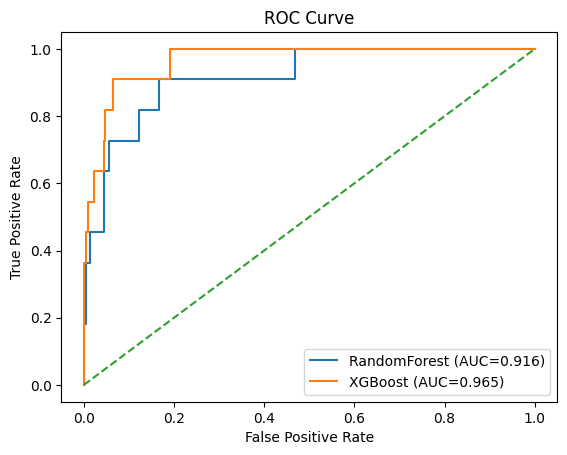

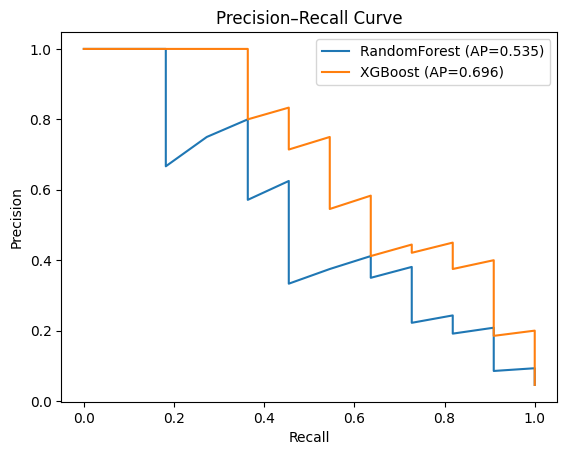

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# 1. Get positive‐class probabilities
rf_probs  = best_rf.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]

# --- ROC Curve ---
rf_fpr, rf_tpr, _   = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
rf_auc  = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure()
plt.plot(rf_fpr, rf_tpr, label=f'RandomForest (AUC={rf_auc:.3f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC={xgb_auc:.3f})')
plt.plot([0,1],[0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# --- Precision–Recall Curve ---
rf_prec, rf_rec, _   = precision_recall_curve(y_test, rf_probs)
xgb_prec, xgb_rec, _ = precision_recall_curve(y_test, xgb_probs)
rf_ap  = average_precision_score(y_test, rf_probs)
xgb_ap = average_precision_score(y_test, xgb_probs)

plt.figure()
plt.plot(rf_rec, rf_prec, label=f'RandomForest (AP={rf_ap:.3f})')
plt.plot(xgb_rec, xgb_prec, label=f'XGBoost (AP={xgb_ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


In [6]:
import optuna
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Load DS A
df = pd.read_csv('fd.csv')
X = df.drop(columns=['Bleaching'])
y = df['Bleaching']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# 4. Define F1 scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

# 5. RF objective for Optuna
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced'
    }
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train_imp, y_train, cv=5, scoring=f1_scorer)
    return scores.mean()

# 6. XGB objective for Optuna
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train_imp, y_train, cv=5, scoring=f1_scorer)
    return scores.mean()

# 7. Run Optuna studies
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)

# 8. Train final models with best params
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_imp, y_train)

best_xgb = xgb.XGBClassifier(**xgb_study.best_params, random_state=42, n_jobs=-1)
best_xgb.fit(X_train_imp, y_train)

# 9. Evaluate on test set
y_pred_rf  = best_rf.predict(X_test_imp)
y_pred_xgb = best_xgb.predict(X_test_imp)

print("Random Forest Test Report:")
print(classification_report(y_test, y_pred_rf, digits=3))

print("\nXGBoost Test Report:")
print(classification_report(y_test, y_pred_xgb, digits=3))

# 10. Best hyperparameters
print("Best RF params:", rf_study.best_params)
print("Best XGB params:", xgb_study.best_params)

[I 2025-05-13 19:02:25,375] A new study created in memory with name: no-name-0e5c3563-2782-4006-9ad2-bfd7ce94ba7b


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-13 19:02:46,919] Trial 0 finished with value: 0.5294314381270903 and parameters: {'n_estimators': 885, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.5294314381270903.
[I 2025-05-13 19:02:50,487] Trial 1 finished with value: 0.5511705685618729 and parameters: {'n_estimators': 349, 'max_depth': 40, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5511705685618729.
[I 2025-05-13 19:02:54,939] Trial 2 finished with value: 0.5257254901960785 and parameters: {'n_estimators': 461, 'max_depth': 36, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.5511705685618729.
[I 2025-05-13 19:03:02,463] Trial 3 finished with value: 0.5569218500797447 and parameters: {'n_estimators': 760, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.55692185007

[I 2025-05-13 19:08:57,076] A new study created in memory with name: no-name-b1b32870-8472-4b14-9bce-f85f0d3a0b04


[I 2025-05-13 19:08:57,070] Trial 49 finished with value: 0.571077694235589 and parameters: {'n_estimators': 476, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 39 with value: 0.6106737431814832.


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:57] WARNING: /workspace/s

[I 2025-05-13 19:08:59,175] Trial 0 finished with value: 0.547407680039259 and parameters: {'n_estimators': 522, 'max_depth': 15, 'learning_rate': 0.006237229596249219, 'subsample': 0.7178099625793072, 'colsample_bytree': 0.5981457062108331}. Best is trial 0 with value: 0.547407680039259.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:59] WARNING: /workspace/s

[I 2025-05-13 19:09:01,182] Trial 1 finished with value: 0.6057971014492753 and parameters: {'n_estimators': 762, 'max_depth': 7, 'learning_rate': 0.029537135357040712, 'subsample': 0.6235214179281837, 'colsample_bytree': 0.9183565764904623}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:01] WARNING: /workspace/s

[I 2025-05-13 19:09:03,215] Trial 2 finished with value: 0.520127408823061 and parameters: {'n_estimators': 532, 'max_depth': 10, 'learning_rate': 0.0020587489500367823, 'subsample': 0.6820630481472978, 'colsample_bytree': 0.5917050353493407}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:03] WARNING: /workspace/s

[I 2025-05-13 19:09:03,790] Trial 3 finished with value: 0.4921321437183506 and parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.003417900610767065, 'subsample': 0.9073837103905107, 'colsample_bytree': 0.7028029954641591}. Best is trial 1 with value: 0.6057971014492753.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-05-13 19:09:05,328] Trial 4 finished with value: 0.5807717823971694 and parameters: {'n_estimators': 537, 'max_depth': 12, 'learning_rate': 0.016372523207773094, 'subsample': 0.5164220633925238, 'colsample_bytree': 0.5402133861661588}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:05] WARNING: /workspace/s

[I 2025-05-13 19:09:08,308] Trial 5 finished with value: 0.585 and parameters: {'n_estimators': 658, 'max_depth': 11, 'learning_rate': 0.0239940095210523, 'subsample': 0.63018678567283, 'colsample_bytree': 0.7404981423390917}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /workspace/s

[I 2025-05-13 19:09:09,573] Trial 6 finished with value: 0.5128571428571428 and parameters: {'n_estimators': 270, 'max_depth': 15, 'learning_rate': 0.003300675466183882, 'subsample': 0.7806867979874059, 'colsample_bytree': 0.6705479062435962}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:09] WARNING: /workspace/s

[I 2025-05-13 19:09:15,605] Trial 7 finished with value: 0.5499137336093858 and parameters: {'n_estimators': 908, 'max_depth': 7, 'learning_rate': 0.0030822136283205643, 'subsample': 0.948811356566204, 'colsample_bytree': 0.9954745693753734}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:15] WARNING: /workspace/s

[I 2025-05-13 19:09:16,817] Trial 8 finished with value: 0.4992857142857142 and parameters: {'n_estimators': 278, 'max_depth': 6, 'learning_rate': 0.0013335733589139888, 'subsample': 0.8629562840907214, 'colsample_bytree': 0.8116656270948464}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:16] WARNING: /workspace/s

[I 2025-05-13 19:09:20,106] Trial 9 finished with value: 0.5783333333333334 and parameters: {'n_estimators': 957, 'max_depth': 9, 'learning_rate': 0.024849479379828277, 'subsample': 0.7394681070449873, 'colsample_bytree': 0.6152229257156534}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:20] WARNING: /workspace/s

[I 2025-05-13 19:09:21,335] Trial 10 finished with value: 0.5999999999999999 and parameters: {'n_estimators': 745, 'max_depth': 3, 'learning_rate': 0.08556716622871224, 'subsample': 0.525758010968806, 'colsample_bytree': 0.9079300208747454}. Best is trial 1 with value: 0.6057971014492753.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:21] WARNING: /workspace/s

[I 2025-05-13 19:09:22,623] Trial 11 finished with value: 0.6297319385420072 and parameters: {'n_estimators': 768, 'max_depth': 3, 'learning_rate': 0.07734789678493574, 'subsample': 0.503957056013666, 'colsample_bytree': 0.9082644976631444}. Best is trial 11 with value: 0.6297319385420072.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:22] WARNING: /workspace/s

[I 2025-05-13 19:09:23,958] Trial 12 finished with value: 0.6464102564102564 and parameters: {'n_estimators': 778, 'max_depth': 6, 'learning_rate': 0.08590662844488633, 'subsample': 0.5814216034998445, 'colsample_bytree': 0.8514653290725457}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:23] WARNING: /workspace/s

[I 2025-05-13 19:09:25,305] Trial 13 finished with value: 0.6397435897435897 and parameters: {'n_estimators': 833, 'max_depth': 5, 'learning_rate': 0.09712085565861722, 'subsample': 0.5616696374693959, 'colsample_bytree': 0.8313758651119927}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:25] WARNING: /workspace/s

[I 2025-05-13 19:09:27,023] Trial 14 finished with value: 0.6178742310321257 and parameters: {'n_estimators': 887, 'max_depth': 5, 'learning_rate': 0.05114761456732895, 'subsample': 0.5860647618397057, 'colsample_bytree': 0.8313689814728626}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:27] WARNING: /workspace/s

[I 2025-05-13 19:09:28,209] Trial 15 finished with value: 0.5853634085213032 and parameters: {'n_estimators': 412, 'max_depth': 5, 'learning_rate': 0.045924901747684106, 'subsample': 0.584263695356704, 'colsample_bytree': 0.83202130181686}. Best is trial 12 with value: 0.6464102564102564.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[I 2025-05-13 19:09:32,935] Trial 16 finished with value: 0.5929824561403508 and parameters: {'n_estimators': 999, 'max_depth': 8, 'learning_rate': 0.010468538589608485, 'subsample': 0.7973023555568137, 'colsample_bytree': 0.7724718283182304}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:32] WARNING: /workspace/s

[I 2025-05-13 19:09:34,557] Trial 17 finished with value: 0.6317494824016563 and parameters: {'n_estimators': 657, 'max_depth': 5, 'learning_rate': 0.04223859657974118, 'subsample': 0.6555088175387352, 'colsample_bytree': 0.9655709306437723}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:34] WARNING: /workspace/s

[I 2025-05-13 19:09:36,027] Trial 18 finished with value: 0.6073751686909581 and parameters: {'n_estimators': 832, 'max_depth': 6, 'learning_rate': 0.09316273098858002, 'subsample': 0.5646123826969752, 'colsample_bytree': 0.8693512648934816}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:36] WARNING: /workspace/s

[I 2025-05-13 19:09:36,647] Trial 19 finished with value: 0.5210207336523125 and parameters: {'n_estimators': 115, 'max_depth': 13, 'learning_rate': 0.01358446603655354, 'subsample': 0.6915749114829279, 'colsample_bytree': 0.7715879782270174}. Best is trial 12 with value: 0.6464102564102564.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2025-05-13 19:09:39,281] Trial 20 finished with value: 0.5528822055137844 and parameters: {'n_estimators': 655, 'max_depth': 9, 'learning_rate': 0.00653605306766875, 'subsample': 0.5526150741350686, 'colsample_bytree': 0.866321091355436}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:39] WARNING: /workspace/s

[I 2025-05-13 19:09:40,864] Trial 21 finished with value: 0.6317494824016563 and parameters: {'n_estimators': 668, 'max_depth': 5, 'learning_rate': 0.04773392277712308, 'subsample': 0.6423385186739118, 'colsample_bytree': 0.9903943960332859}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:40] WARNING: /workspace/s

[I 2025-05-13 19:09:43,486] Trial 22 finished with value: 0.6443893825472773 and parameters: {'n_estimators': 822, 'max_depth': 4, 'learning_rate': 0.06377149738806386, 'subsample': 0.6404158777119413, 'colsample_bytree': 0.9595763803183478}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:43] WARNING: /workspace/s

[I 2025-05-13 19:09:45,025] Trial 23 finished with value: 0.6172727272727272 and parameters: {'n_estimators': 859, 'max_depth': 4, 'learning_rate': 0.06480402389547188, 'subsample': 0.6113374630008653, 'colsample_bytree': 0.9348384091327064}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:45] WARNING: /workspace/s

[I 2025-05-13 19:09:46,381] Trial 24 finished with value: 0.6415261209378856 and parameters: {'n_estimators': 788, 'max_depth': 7, 'learning_rate': 0.09915616904423184, 'subsample': 0.5511361765220333, 'colsample_bytree': 0.8725534658123546}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:46] WARNING: /workspace/s

[I 2025-05-13 19:09:48,233] Trial 25 finished with value: 0.6006015037593985 and parameters: {'n_estimators': 729, 'max_depth': 7, 'learning_rate': 0.034166216598149335, 'subsample': 0.6816710508612356, 'colsample_bytree': 0.8844728050212332}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:48] WARNING: /workspace/s

[I 2025-05-13 19:09:49,587] Trial 26 finished with value: 0.5707142857142856 and parameters: {'n_estimators': 586, 'max_depth': 8, 'learning_rate': 0.06264829027863995, 'subsample': 0.5990106770879938, 'colsample_bytree': 0.9450905898908901}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:49] WARNING: /workspace/s

[I 2025-05-13 19:09:50,903] Trial 27 finished with value: 0.5228995840760546 and parameters: {'n_estimators': 452, 'max_depth': 4, 'learning_rate': 0.019552343691412528, 'subsample': 0.5366212371965574, 'colsample_bytree': 0.9663489067862837}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:50] WARNING: /workspace/s

[I 2025-05-13 19:09:53,556] Trial 28 finished with value: 0.6443893825472773 and parameters: {'n_estimators': 794, 'max_depth': 6, 'learning_rate': 0.058947951977399715, 'subsample': 0.8044317671503473, 'colsample_bytree': 0.7974525416124282}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:53] WARNING: /workspace/s

[I 2025-05-13 19:09:55,417] Trial 29 finished with value: 0.6309523809523809 and parameters: {'n_estimators': 944, 'max_depth': 4, 'learning_rate': 0.03656477432481073, 'subsample': 0.819252399621238, 'colsample_bytree': 0.7939658237024346}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:55] WARNING: /workspace/s

[I 2025-05-13 19:09:56,686] Trial 30 finished with value: 0.6192857142857142 and parameters: {'n_estimators': 590, 'max_depth': 6, 'learning_rate': 0.060456111249146224, 'subsample': 0.7345987677379133, 'colsample_bytree': 0.7344236060686326}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:56] WARNING: /workspace/s

[I 2025-05-13 19:09:58,179] Trial 31 finished with value: 0.6262075643654591 and parameters: {'n_estimators': 799, 'max_depth': 8, 'learning_rate': 0.06970380990996225, 'subsample': 0.8414275884004313, 'colsample_bytree': 0.8520321446376161}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:58] WARNING: /workspace/s

[I 2025-05-13 19:09:59,466] Trial 32 finished with value: 0.5853634085213033 and parameters: {'n_estimators': 724, 'max_depth': 7, 'learning_rate': 0.09182700552751505, 'subsample': 0.7684803658489564, 'colsample_bytree': 0.8854685286380732}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:59] WARNING: /workspace/s

[I 2025-05-13 19:10:01,555] Trial 33 finished with value: 0.6185994397759104 and parameters: {'n_estimators': 787, 'max_depth': 6, 'learning_rate': 0.02788829342573329, 'subsample': 0.996022216891224, 'colsample_bytree': 0.7944442056141015}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:01] WARNING: /workspace/s

[I 2025-05-13 19:10:02,969] Trial 34 finished with value: 0.6126190476190476 and parameters: {'n_estimators': 709, 'max_depth': 4, 'learning_rate': 0.056740832071077545, 'subsample': 0.6695681815221157, 'colsample_bytree': 0.9084239315454549}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:03] WARNING: /workspace/s

[I 2025-05-13 19:10:05,530] Trial 35 finished with value: 0.5096796478375426 and parameters: {'n_estimators': 895, 'max_depth': 6, 'learning_rate': 0.09980508423620964, 'subsample': 0.7153402328025045, 'colsample_bytree': 0.7032337123056218}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:05] WARNING: /workspace/s

[I 2025-05-13 19:10:07,750] Trial 36 finished with value: 0.6142857142857142 and parameters: {'n_estimators': 811, 'max_depth': 10, 'learning_rate': 0.03537826271104602, 'subsample': 0.8710043963627997, 'colsample_bytree': 0.941431260560289}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:07] WARNING: /workspace/s

[I 2025-05-13 19:10:08,808] Trial 37 finished with value: 0.6057017543859649 and parameters: {'n_estimators': 480, 'max_depth': 8, 'learning_rate': 0.07117361804855236, 'subsample': 0.6257396876731547, 'colsample_bytree': 0.5181912418293388}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:08] WARNING: /workspace/s

[I 2025-05-13 19:10:11,639] Trial 38 finished with value: 0.5079365079365079 and parameters: {'n_estimators': 597, 'max_depth': 9, 'learning_rate': 0.006538914016208022, 'subsample': 0.7004651817829008, 'colsample_bytree': 0.8518664015977008}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:11] WARNING: /workspace/s

[I 2025-05-13 19:10:13,682] Trial 39 finished with value: 0.6304761904761904 and parameters: {'n_estimators': 946, 'max_depth': 7, 'learning_rate': 0.04290041517821887, 'subsample': 0.9161288464920904, 'colsample_bytree': 0.6665346476134466}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:13] WARNING: /workspace/s

[I 2025-05-13 19:10:16,728] Trial 40 finished with value: 0.5565804002760524 and parameters: {'n_estimators': 848, 'max_depth': 3, 'learning_rate': 0.019659438127912217, 'subsample': 0.5020920359262312, 'colsample_bytree': 0.7644038914341014}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:16] WARNING: /workspace/s

[I 2025-05-13 19:10:18,077] Trial 41 finished with value: 0.6214102564102564 and parameters: {'n_estimators': 858, 'max_depth': 5, 'learning_rate': 0.09987023794066943, 'subsample': 0.5593612887666345, 'colsample_bytree': 0.8335614455237792}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:18] WARNING: /workspace/s

[I 2025-05-13 19:10:19,437] Trial 42 finished with value: 0.6203496503496504 and parameters: {'n_estimators': 777, 'max_depth': 6, 'learning_rate': 0.07643294079913639, 'subsample': 0.5780144612717155, 'colsample_bytree': 0.7234220135282337}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:19] WARNING: /workspace/s

[I 2025-05-13 19:10:20,870] Trial 43 finished with value: 0.6154462242562928 and parameters: {'n_estimators': 684, 'max_depth': 4, 'learning_rate': 0.05345784483680994, 'subsample': 0.5375185186267518, 'colsample_bytree': 0.8192024320849715}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:20] WARNING: /workspace/s

[I 2025-05-13 19:10:22,438] Trial 44 finished with value: 0.643073593073593 and parameters: {'n_estimators': 913, 'max_depth': 5, 'learning_rate': 0.07793115396014455, 'subsample': 0.6167277275704811, 'colsample_bytree': 0.8889417335130013}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:22] WARNING: /workspace/s

[I 2025-05-13 19:10:27,812] Trial 45 finished with value: 0.5109774436090226 and parameters: {'n_estimators': 986, 'max_depth': 14, 'learning_rate': 0.0022998685104375456, 'subsample': 0.6101437256323632, 'colsample_bytree': 0.889626433323528}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:27] WARNING: /workspace/s

[I 2025-05-13 19:10:29,431] Trial 46 finished with value: 0.6049999999999999 and parameters: {'n_estimators': 918, 'max_depth': 7, 'learning_rate': 0.07660488376690362, 'subsample': 0.648940255511419, 'colsample_bytree': 0.923743035956436}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:29] WARNING: /workspace/s

[I 2025-05-13 19:10:30,737] Trial 47 finished with value: 0.6316666666666666 and parameters: {'n_estimators': 752, 'max_depth': 3, 'learning_rate': 0.0782989076844053, 'subsample': 0.7579340677523608, 'colsample_bytree': 0.9732762395733994}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:30] WARNING: /workspace/s

[I 2025-05-13 19:10:34,296] Trial 48 finished with value: 0.5313227513227512 and parameters: {'n_estimators': 888, 'max_depth': 6, 'learning_rate': 0.0010878469123612032, 'subsample': 0.7955488661696822, 'colsample_bytree': 0.7920064857789181}. Best is trial 12 with value: 0.6464102564102564.


<ipython-input-6-f34f0a0dda05>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-6-f34f0a0dda05>:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-6-f34f0a0dda05>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:10:34] WARNING: /workspace/s

[I 2025-05-13 19:10:35,390] Trial 49 finished with value: 0.5547237076648841 and parameters: {'n_estimators': 345, 'max_depth': 5, 'learning_rate': 0.03216670182539319, 'subsample': 0.5961831962875125, 'colsample_bytree': 0.8600031725812072}. Best is trial 12 with value: 0.6464102564102564.
Random Forest Test Report:
              precision    recall  f1-score   support

         0.0      0.962     0.996     0.979       229
         1.0      0.667     0.182     0.286        11

    accuracy                          0.958       240
   macro avg      0.814     0.589     0.632       240
weighted avg      0.948     0.958     0.947       240


XGBoost Test Report:
              precision    recall  f1-score   support

         0.0      0.974     1.000     0.987       229
         1.0      1.000     0.455     0.625        11

    accuracy                          0.975       240
   macro avg      0.987     0.727     0.806       240
weighted avg      0.976     0.975     0.970       240

Best 

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, precision_recall_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Load DS A
df = pd.read_csv('fd.csv')
X = df.drop(columns='Bleaching')
y = df['Bleaching']

# 2. Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Build imputing + SMOTE pipeline step
imputer = SimpleImputer(strategy='median')
smote   = SMOTE(sampling_strategy='minority', random_state=42)

# 4. Define an F2 scorer (β=2)
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

# 5a. RandomForest pipeline + param grid (including class_weight variants)
rf_pipe = Pipeline([
    ('impute', imputer),
    ('smote',  smote),
    ('clf',    RandomForestClassifier(random_state=42, n_jobs=-1))
])
rf_param = {
    # algorithm hyperparams
    'clf__n_estimators':   [100,200,500],
    'clf__max_depth':      [None,10,20,30],
    'clf__min_samples_leaf':[1,2,4],
    # try different ways to weight the positives
    'clf__class_weight':   [None, 'balanced', {0:1,1:5}, {0:1,1:10}]
}

rf_search = RandomizedSearchCV(
    rf_pipe, rf_param,
    n_iter=30, cv=5,
    scoring=f2_scorer,
    refit=True,
    random_state=42, n_jobs=-1, verbose=1
)
rf_search.fit(X_tr, y_tr)
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

# 5b. XGBoost pipeline + param grid (incl. scale_pos_weight)
# compute neg/pos ratio once
neg, pos = (y_tr==0).sum(), (y_tr==1).sum()
scale_pw = neg/pos

xgb_pipe = Pipeline([
    ('impute', imputer),
    ('smote',  smote),
    ('clf',    xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])
xgb_param = {
    'clf__n_estimators':   [100,200,500],
    'clf__max_depth':      [3,6,9],
    'clf__learning_rate':  [0.01,0.1,0.2],
    'clf__subsample':      [0.6,0.8,1.0],
    'clf__scale_pos_weight':[scale_pw, scale_pw*2, scale_pw*5]
}

xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_param,
    n_iter=30, cv=5,
    scoring=f2_scorer,
    refit=True,
    random_state=42, n_jobs=-1, verbose=1
)
xgb_search.fit(X_tr, y_tr)
best_xgb = xgb_search.best_estimator_
print("Best XGB params:", xgb_search.best_params_)

# 6. Threshold-tuning helper to maximize F2 on a small val split
def choose_thresh(model, X_val, y_val, beta=2):
    probs = model.predict_proba(X_val)[:,1]
    p, r, t = precision_recall_curve(y_val, probs)
    beta2 = beta**2
    f2 = (1+beta2)*(p*r)/(beta2*p + r + 1e-8)
    idx = np.nanargmax(f2)
    return t[idx], f2[idx]

# 7. Split off a val set for threshold tuning
X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_tr, y_tr, stratify=y_tr, test_size=0.2, random_state=42
)

# Refit best pipelines on X_tr2
best_rf.fit(X_tr2, y_tr2)
best_xgb.fit(X_tr2, y_tr2)

# Find thresholds that maximize F2 on the val set
rf_thresh, rf_f2 = choose_thresh(best_rf, best_rf.named_steps['impute'].transform(X_val), y_val, beta=2)
xgb_thresh, xgb_f2 = choose_thresh(best_xgb, best_xgb.named_steps['impute'].transform(X_val), y_val, beta=2)

print(f"RF threshold={rf_thresh:.3f}, val-F2={rf_f2:.3f}")
print(f"XGB threshold={xgb_thresh:.3f}, val-F2={xgb_f2:.3f}")

# 8. Final evaluation on the hold-out test set
X_te_imp = best_rf.named_steps['impute'].transform(X_te)

for name, (pipe, thresh) in [
    ('RandomForest',(best_rf, rf_thresh)),
    ('XGBoost',     (best_xgb, xgb_thresh))
]:
    probs = pipe.predict_proba(X_te_imp)[:,1]
    preds = (probs >= thresh).astype(int)
    print(f"\n{name} @ thresh={thresh:.3f}")
    print(classification_report(y_te, preds, digits=3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'clf__n_estimators': 500, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__class_weight': {0: 1, 1: 10}}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:16:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB params: {'clf__subsample': 1.0, 'clf__scale_pos_weight': np.float64(21.325581395348838), 'clf__n_estimators': 500, 'clf__max_depth': 6, 'clf__learning_rate': 0.2}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:16:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


RF threshold=0.598, val-F2=0.686
XGB threshold=0.528, val-F2=0.700

RandomForest @ thresh=0.598
              precision    recall  f1-score   support

         0.0      0.973     0.948     0.960       229
         1.0      0.294     0.455     0.357        11

    accuracy                          0.925       240
   macro avg      0.634     0.701     0.659       240
weighted avg      0.942     0.925     0.933       240


XGBoost @ thresh=0.528
              precision    recall  f1-score   support

         0.0      0.978     0.961     0.969       229
         1.0      0.400     0.545     0.462        11

    accuracy                          0.942       240
   macro avg      0.689     0.753     0.715       240
weighted avg      0.951     0.942     0.946       240



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, precision_recall_curve, classification_report

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# -- 1. Load data --
df = pd.read_csv('fd.csv')
X = df.drop(columns='Bleaching')
y = df['Bleaching']

# -- 2. Train/test split --
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -- 3. Imputer & oversampler (try heavier SMOTE or ADASYN) --
imputer = SimpleImputer(strategy='median')
oversampler = SMOTE(sampling_strategy=0.8, random_state=42)
# oversampler = ADASYN(sampling_strategy=0.8, random_state=42)

# -- 4. F3 scorer (heavier on recall) --
f3 = make_scorer(fbeta_score, beta=3, pos_label=1)

# -- 5a. RF pipeline & param grid --
rf_pipe = Pipeline([
    ('impute', imputer),
    ('over',   oversampler),
    ('clf',    RandomForestClassifier(random_state=42, n_jobs=-1))
])
rf_param = {
    'clf__n_estimators':   [200, 500, 800],
    'clf__max_depth':      [10, 20, None],
    'clf__min_samples_leaf':[1, 2, 4],
    # push positive weight very high
    'clf__class_weight':   [ {0:1,1:5}, {0:1,1:10}, {0:1,1:20} ]
}

rf_search = RandomizedSearchCV(
    rf_pipe, rf_param,
    n_iter=30, cv=5,
    scoring=f3,
    refit=True,
    random_state=42, n_jobs=-1, verbose=1
)
rf_search.fit(X_tr, y_tr)
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

# -- 5b. XGB pipeline & param grid --
pos, neg = y_tr.sum(), (y_tr==0).sum()
spf = neg/pos
xgb_pipe = Pipeline([
    ('impute', imputer),
    ('over',   oversampler),
    ('clf',    xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42, n_jobs=-1
    ))
])
xgb_param = {
    'clf__n_estimators':     [200, 500, 800],
    'clf__max_depth':        [4, 8, 12],
    'clf__learning_rate':    [0.01,0.05,0.1],
    'clf__subsample':        [0.7, 0.9, 1.0],
    'clf__scale_pos_weight': [spf, spf*2, spf*5]
}

xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_param,
    n_iter=30, cv=5,
    scoring=f3,
    refit=True,
    random_state=42, n_jobs=-1, verbose=1
)
xgb_search.fit(X_tr, y_tr)
best_xgb = xgb_search.best_estimator_
print("Best XGB params:", xgb_search.best_params_)

# -- 6. Threshold tuning helper: pick lowest threshold with recall ≥ 0.7 --
def pick_thresh(model, X_val, y_val, min_recall=0.7, beta=3):
    probs = model.predict_proba(X_val)[:,1]
    p, r, t = precision_recall_curve(y_val, probs)
    candidates = [(prec, rec, thr) for prec,rec,thr in zip(p,r,t) if rec>=min_recall]
    if not candidates:
        return 0.5
    # maximize precision among those meeting min_recall
    return max(candidates, key=lambda x: x[0])[2]

# split out a small val set
X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_tr, y_tr, stratify=y_tr, test_size=0.2, random_state=42
)

# refit on this smaller training slice
best_rf.fit(X_tr2, y_tr2)
best_xgb.fit(X_tr2, y_tr2)

# find thresholds
rf_thr  = pick_thresh(best_rf, best_rf.named_steps['impute'].transform(X_val), y_val)
xgb_thr = pick_thresh(best_xgb, best_xgb.named_steps['impute'].transform(X_val), y_val)
print(f"RF threshold: {rf_thr:.3f}, XGB threshold: {xgb_thr:.3f}")

# -- 7. Evaluate on the held-out test set --
X_te_imp = best_rf.named_steps['impute'].transform(X_te)
for name,(model,thr) in [
    ('RandomForest',(best_rf, rf_thr)),
    ('XGBoost',     (best_xgb, xgb_thr))
]:
    prob = model.predict_proba(X_te_imp)[:,1]
    pred = (prob>=thr).astype(int)
    print(f"\n{name} @ thresh={thr:.3f}")
    print(classification_report(y_te, pred, digits=3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'clf__n_estimators': 500, 'clf__min_samples_leaf': 4, 'clf__max_depth': 20, 'clf__class_weight': {0: 1, 1: 20}}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB params: {'clf__subsample': 0.9, 'clf__scale_pos_weight': np.float64(21.325581395348838), 'clf__n_estimators': 200, 'clf__max_depth': 4, 'clf__learning_rate': 0.05}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


RF threshold: 0.665, XGB threshold: 0.456

RandomForest @ thresh=0.665
              precision    recall  f1-score   support

         0.0      0.973     0.943     0.958       229
         1.0      0.278     0.455     0.345        11

    accuracy                          0.921       240
   macro avg      0.625     0.699     0.651       240
weighted avg      0.941     0.921     0.930       240


XGBoost @ thresh=0.456
              precision    recall  f1-score   support

         0.0      0.977     0.939     0.958       229
         1.0      0.300     0.545     0.387        11

    accuracy                          0.921       240
   macro avg      0.639     0.742     0.672       240
weighted avg      0.946     0.921     0.932       240



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [9]:
import optuna
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, fbeta_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Load the dataset
df = pd.read_csv('fd.csv')
X = df.drop(columns=['Bleaching'])
y = df['Bleaching']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# 4. Define an F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

# 5a. Random Forest Objective
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced'
    }
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train_imp, y_train,
                             cv=5, scoring=f2_scorer, n_jobs=-1)
    return scores.mean()

# 5b. XGBoost Objective
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    scores = cross_val_score(model, X_train_imp, y_train,
                             cv=5, scoring=f2_scorer, n_jobs=-1)
    return scores.mean()

# 6. Run Optuna studies maximizing F2
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=50, show_progress_bar=True)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)

# 7. Train final models with best parameters
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_imp, y_train)

best_xgb = xgb.XGBClassifier(**xgb_study.best_params,
                             random_state=42, n_jobs=-1,
                             use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_imp, y_train)

# 8. Evaluate on test set
y_pred_rf  = best_rf.predict(X_test_imp)
y_pred_xgb = best_xgb.predict(X_test_imp)

print("Random Forest Test Report (F2-optimized):")
print(classification_report(y_test, y_pred_rf, digits=3))

print("\nXGBoost Test Report (F2-optimized):")
print(classification_report(y_test, y_pred_xgb, digits=3))

# 9. Best hyperparameters
print("Best RF params:", rf_study.best_params)
print("Best XGB params:", xgb_study.best_params)


[I 2025-05-13 19:37:45,654] A new study created in memory with name: no-name-679b6c73-11f1-47c0-9cec-1f130c7c371c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-13 19:37:51,342] Trial 0 finished with value: 0.6315584446338922 and parameters: {'n_estimators': 626, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6315584446338922.
[I 2025-05-13 19:37:52,560] Trial 1 finished with value: 0.6281912167935612 and parameters: {'n_estimators': 173, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.6315584446338922.
[I 2025-05-13 19:37:54,649] Trial 2 finished with value: 0.6266668170844522 and parameters: {'n_estimators': 291, 'max_depth': 39, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6315584446338922.
[I 2025-05-13 19:38:00,915] Trial 3 finished with value: 0.5949489293834198 and parameters: {'n_estimators': 794, 'max_depth': 45, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.63155844463

[I 2025-05-13 19:41:48,103] A new study created in memory with name: no-name-894d6ded-7b8b-4b8f-8323-837600a807ac


[I 2025-05-13 19:41:48,100] Trial 49 finished with value: 0.5929057466040499 and parameters: {'n_estimators': 775, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 47 with value: 0.6555306868072825.


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:50,140] Trial 0 finished with value: 0.5353419871946079 and parameters: {'n_estimators': 441, 'max_depth': 8, 'learning_rate': 0.0034032161098165293, 'subsample': 0.6998263574478054, 'colsample_bytree': 0.8796417987754568}. Best is trial 0 with value: 0.5353419871946079.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:51,668] Trial 1 finished with value: 0.5907817086191904 and parameters: {'n_estimators': 771, 'max_depth': 10, 'learning_rate': 0.08107417305356493, 'subsample': 0.7555061866140852, 'colsample_bytree': 0.8224132805348368}. Best is trial 1 with value: 0.5907817086191904.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:52,747] Trial 2 finished with value: 0.5959149162775608 and parameters: {'n_estimators': 908, 'max_depth': 10, 'learning_rate': 0.09339553955343712, 'subsample': 0.9080033525882704, 'colsample_bytree': 0.5782536929085103}. Best is trial 2 with value: 0.5959149162775608.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:54,131] Trial 3 finished with value: 0.5574633711991456 and parameters: {'n_estimators': 349, 'max_depth': 8, 'learning_rate': 0.0028968349554293928, 'subsample': 0.6184597183670839, 'colsample_bytree': 0.9734035907997508}. Best is trial 2 with value: 0.5959149162775608.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:55,300] Trial 4 finished with value: 0.5602072459177443 and parameters: {'n_estimators': 298, 'max_depth': 15, 'learning_rate': 0.039127318542374376, 'subsample': 0.5881354054002623, 'colsample_bytree': 0.6466500139044429}. Best is trial 2 with value: 0.5959149162775608.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:57,968] Trial 5 finished with value: 0.5596033868092691 and parameters: {'n_estimators': 599, 'max_depth': 6, 'learning_rate': 0.0025460373844445267, 'subsample': 0.9795534906127094, 'colsample_bytree': 0.9077997071613647}. Best is trial 2 with value: 0.5959149162775608.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:58,677] Trial 6 finished with value: 0.6064895470383276 and parameters: {'n_estimators': 319, 'max_depth': 6, 'learning_rate': 0.037002615113275836, 'subsample': 0.8536978494493892, 'colsample_bytree': 0.5013579928002969}. Best is trial 6 with value: 0.6064895470383276.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:58,977] Trial 7 finished with value: 0.6071180972388956 and parameters: {'n_estimators': 126, 'max_depth': 3, 'learning_rate': 0.022997304094057137, 'subsample': 0.982045717450009, 'colsample_bytree': 0.8282189005018384}. Best is trial 7 with value: 0.6071180972388956.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:41:59,293] Trial 8 finished with value: 0.5661312937112167 and parameters: {'n_estimators': 126, 'max_depth': 5, 'learning_rate': 0.09716298698236821, 'subsample': 0.8561130441115048, 'colsample_bytree': 0.5413940246664188}. Best is trial 7 with value: 0.6071180972388956.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:00,817] Trial 9 finished with value: 0.638400379926852 and parameters: {'n_estimators': 915, 'max_depth': 3, 'learning_rate': 0.007425214986863214, 'subsample': 0.8312222927250261, 'colsample_bytree': 0.8314499103619564}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:04,346] Trial 10 finished with value: 0.5320464666456749 and parameters: {'n_estimators': 979, 'max_depth': 13, 'learning_rate': 0.008600391967940768, 'subsample': 0.7557218105357274, 'colsample_bytree': 0.739882775398693}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:05,841] Trial 11 finished with value: 0.5809209255201339 and parameters: {'n_estimators': 674, 'max_depth': 4, 'learning_rate': 0.010992022926621367, 'subsample': 0.9908008459043147, 'colsample_bytree': 0.766970637421056}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:06,096] Trial 12 finished with value: 0.6016117526954681 and parameters: {'n_estimators': 110, 'max_depth': 3, 'learning_rate': 0.010268106064676244, 'subsample': 0.9018812663851676, 'colsample_bytree': 0.7119063122132249}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:07,298] Trial 13 finished with value: 0.6244984040127679 and parameters: {'n_estimators': 798, 'max_depth': 3, 'learning_rate': 0.023347743403758496, 'subsample': 0.5125117419348246, 'colsample_bytree': 0.8386182697260265}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:09,719] Trial 14 finished with value: 0.5382584529039611 and parameters: {'n_estimators': 818, 'max_depth': 6, 'learning_rate': 0.005580051909604269, 'subsample': 0.6634617119414798, 'colsample_bytree': 0.9392987106350962}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:12,235] Trial 15 finished with value: 0.6227983920841064 and parameters: {'n_estimators': 788, 'max_depth': 3, 'learning_rate': 0.0012934853778469582, 'subsample': 0.5286777875667887, 'colsample_bytree': 0.8264709086941744}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:16,797] Trial 16 finished with value: 0.5779286770140428 and parameters: {'n_estimators': 998, 'max_depth': 12, 'learning_rate': 0.01872558832016078, 'subsample': 0.5002118238891882, 'colsample_bytree': 0.6679125534747129}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:20,037] Trial 17 finished with value: 0.5813474316381293 and parameters: {'n_estimators': 671, 'max_depth': 5, 'learning_rate': 0.018808732261865215, 'subsample': 0.8006660777812737, 'colsample_bytree': 0.870099070348303}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:23,470] Trial 18 finished with value: 0.5414635811090894 and parameters: {'n_estimators': 865, 'max_depth': 8, 'learning_rate': 0.00466147517785371, 'subsample': 0.6846309475831165, 'colsample_bytree': 0.9927255953341794}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:24,660] Trial 19 finished with value: 0.6031672879021148 and parameters: {'n_estimators': 690, 'max_depth': 5, 'learning_rate': 0.04278332864095272, 'subsample': 0.8071722507612846, 'colsample_bytree': 0.7918952763176439}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:27,915] Trial 20 finished with value: 0.573982683982684 and parameters: {'n_estimators': 915, 'max_depth': 7, 'learning_rate': 0.0011851483277097177, 'subsample': 0.5637794227975841, 'colsample_bytree': 0.7207671465231393}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:29,346] Trial 21 finished with value: 0.6235453982461805 and parameters: {'n_estimators': 782, 'max_depth': 3, 'learning_rate': 0.0013991221977774878, 'subsample': 0.5256431193732635, 'colsample_bytree': 0.8458694349570346}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:31,145] Trial 22 finished with value: 0.6211583447608292 and parameters: {'n_estimators': 745, 'max_depth': 4, 'learning_rate': 0.002090225065862341, 'subsample': 0.631109505790192, 'colsample_bytree': 0.8639496450930622}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:32,433] Trial 23 finished with value: 0.6195228611103704 and parameters: {'n_estimators': 549, 'max_depth': 4, 'learning_rate': 0.006715501645022122, 'subsample': 0.5491223199719503, 'colsample_bytree': 0.9236036680419946}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:33,853] Trial 24 finished with value: 0.5718304713189624 and parameters: {'n_estimators': 866, 'max_depth': 3, 'learning_rate': 0.014288912670197858, 'subsample': 0.5095416677426583, 'colsample_bytree': 0.7734054492645386}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:35,288] Trial 25 finished with value: 0.6294573643410852 and parameters: {'n_estimators': 594, 'max_depth': 4, 'learning_rate': 0.0017128631386923257, 'subsample': 0.5794546595167461, 'colsample_bytree': 0.8106001363824596}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:36,417] Trial 26 finished with value: 0.5916666666666667 and parameters: {'n_estimators': 562, 'max_depth': 4, 'learning_rate': 0.027878152580121354, 'subsample': 0.5887124559384997, 'colsample_bytree': 0.7972693108141501}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:37,503] Trial 27 finished with value: 0.6035133565621371 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.06044156632600681, 'subsample': 0.7257304691369344, 'colsample_bytree': 0.6828864670415091}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:39,756] Trial 28 finished with value: 0.5751441241685145 and parameters: {'n_estimators': 631, 'max_depth': 7, 'learning_rate': 0.0017842696361814337, 'subsample': 0.6511230021086072, 'colsample_bytree': 0.6138744893844902}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:41,526] Trial 29 finished with value: 0.5353419871946079 and parameters: {'n_estimators': 467, 'max_depth': 9, 'learning_rate': 0.0036866959013971278, 'subsample': 0.701192537505675, 'colsample_bytree': 0.8954265386893449}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:44,205] Trial 30 finished with value: 0.5845198279980889 and parameters: {'n_estimators': 715, 'max_depth': 7, 'learning_rate': 0.004237690346754123, 'subsample': 0.7952032843949015, 'colsample_bytree': 0.9579882374926452}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:45,691] Trial 31 finished with value: 0.6227983920841064 and parameters: {'n_estimators': 827, 'max_depth': 3, 'learning_rate': 0.0010109715977973457, 'subsample': 0.5487402394437001, 'colsample_bytree': 0.8446741439068215}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:47,818] Trial 32 finished with value: 0.6203080046247748 and parameters: {'n_estimators': 934, 'max_depth': 4, 'learning_rate': 0.0015546323510666827, 'subsample': 0.5870341831213051, 'colsample_bytree': 0.8682501272829789}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:49,350] Trial 33 finished with value: 0.6373182606375885 and parameters: {'n_estimators': 751, 'max_depth': 3, 'learning_rate': 0.0024215652851078745, 'subsample': 0.5259506450700266, 'colsample_bytree': 0.8074588239888943}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:51,340] Trial 34 finished with value: 0.616798418972332 and parameters: {'n_estimators': 741, 'max_depth': 4, 'learning_rate': 0.0022956722596783495, 'subsample': 0.6220254975833922, 'colsample_bytree': 0.8022575816866429}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:52,420] Trial 35 finished with value: 0.5929266666071992 and parameters: {'n_estimators': 415, 'max_depth': 5, 'learning_rate': 0.007273216455269484, 'subsample': 0.5750622385226617, 'colsample_bytree': 0.7658979053739727}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:55,205] Trial 36 finished with value: 0.5444938841393924 and parameters: {'n_estimators': 877, 'max_depth': 10, 'learning_rate': 0.0034206170999747203, 'subsample': 0.5395822503784915, 'colsample_bytree': 0.8957846206621048}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:57,413] Trial 37 finished with value: 0.55568865916692 and parameters: {'n_estimators': 633, 'max_depth': 6, 'learning_rate': 0.0029310516562951233, 'subsample': 0.9179080700663141, 'colsample_bytree': 0.7385484856564163}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:58,921] Trial 38 finished with value: 0.6098320208813686 and parameters: {'n_estimators': 949, 'max_depth': 3, 'learning_rate': 0.013898941621308647, 'subsample': 0.8532330101073426, 'colsample_bytree': 0.8105460187182663}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:42:59,722] Trial 39 finished with value: 0.5744427141485965 and parameters: {'n_estimators': 223, 'max_depth': 15, 'learning_rate': 0.0019181050609704115, 'subsample': 0.5997793167636956, 'colsample_bytree': 0.8460795346702337}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:03,426] Trial 40 finished with value: 0.5411215595998204 and parameters: {'n_estimators': 822, 'max_depth': 12, 'learning_rate': 0.00284278630603125, 'subsample': 0.7690651734868645, 'colsample_bytree': 0.7819494366451301}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:04,772] Trial 41 finished with value: 0.6254579665521914 and parameters: {'n_estimators': 780, 'max_depth': 3, 'learning_rate': 0.001323738481544642, 'subsample': 0.5200684630636445, 'colsample_bytree': 0.839381708792738}. Best is trial 9 with value: 0.638400379926852.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:06,384] Trial 42 finished with value: 0.644465058750773 and parameters: {'n_estimators': 749, 'max_depth': 4, 'learning_rate': 0.0015853989454949194, 'subsample': 0.5155500509619765, 'colsample_bytree': 0.8295222645160203}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:08,022] Trial 43 finished with value: 0.6232065553494125 and parameters: {'n_estimators': 747, 'max_depth': 4, 'learning_rate': 0.0010786363602776716, 'subsample': 0.5645315871538787, 'colsample_bytree': 0.812004318147891}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:09,826] Trial 44 finished with value: 0.5629940002608582 and parameters: {'n_estimators': 612, 'max_depth': 6, 'learning_rate': 0.0016211045761665864, 'subsample': 0.5303881897487474, 'colsample_bytree': 0.8849916007554828}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:11,132] Trial 45 finished with value: 0.6415665080261352 and parameters: {'n_estimators': 568, 'max_depth': 4, 'learning_rate': 0.002597549618776271, 'subsample': 0.6113330516549177, 'colsample_bytree': 0.747478802859008}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:13,057] Trial 46 finished with value: 0.5970957351226319 and parameters: {'n_estimators': 569, 'max_depth': 5, 'learning_rate': 0.0024801999498356465, 'subsample': 0.6175078816413107, 'colsample_bytree': 0.749548213486189}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:14,857] Trial 47 finished with value: 0.6156714659582375 and parameters: {'n_estimators': 527, 'max_depth': 5, 'learning_rate': 0.005181271166417205, 'subsample': 0.8810385993965961, 'colsample_bytree': 0.6993961673770653}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:15,865] Trial 48 finished with value: 0.577485139323521 and parameters: {'n_estimators': 398, 'max_depth': 4, 'learning_rate': 0.003939304289560107, 'subsample': 0.8272688434610699, 'colsample_bytree': 0.7347335028591059}. Best is trial 42 with value: 0.644465058750773.


<ipython-input-9-09622cd4cd71>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
<ipython-input-9-09622cd4cd71>:54: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-9-09622cd4cd71>:55: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),


[I 2025-05-13 19:43:18,082] Trial 49 finished with value: 0.5438856226655523 and parameters: {'n_estimators': 657, 'max_depth': 14, 'learning_rate': 0.0027759630551294715, 'subsample': 0.6497897017444644, 'colsample_bytree': 0.7661022467497528}. Best is trial 42 with value: 0.644465058750773.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Test Report (F2-optimized):
              precision    recall  f1-score   support

         0.0      0.962     1.000     0.981       229
         1.0      1.000     0.182     0.308        11

    accuracy                          0.963       240
   macro avg      0.981     0.591     0.644       240
weighted avg      0.964     0.963     0.950       240


XGBoost Test Report (F2-optimized):
              precision    recall  f1-score   support

         0.0      0.954     1.000     0.977       229
         1.0      0.000     0.000     0.000        11

    accuracy                          0.954       240
   macro avg      0.477     0.500     0.488       240
weighted avg      0.910     0.954     0.932       240

Best RF params: {'n_estimators': 790, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}
Best XGB params: {'n_estimators': 749, 'max_depth': 4, 'learning_rate': 0.0015853989454949194, 'subsample': 0.5155500509619765, 'colsample_by

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1. Load and split
df = pd.read_csv('fd.csv')
X = df.drop(columns='Bleaching')
y = df['Bleaching']
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Shared pipeline parts
imputer   = SimpleImputer(strategy='median')
oversampler = SMOTE(sampling_strategy='minority', random_state=42)

def build_pipeline(trial):
    """Constructs a RF pipeline from optuna trial params."""
    n_estimators    = trial.suggest_int('n_estimators', 100, 1000)
    max_depth       = trial.suggest_int('max_depth', 5, 50)
    min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 10)
    weight_pos      = trial.suggest_float('pos_weight', 1.0, 20.0)
    # class_weight for RF takes dict {0:w0,1:w1}
    cw = {0:1, 1:weight_pos}

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight=cw,
        n_jobs=-1,
        random_state=42
    )
    return Pipeline([
        ('impute', imputer),
        ('smote', oversampler),
        ('clf', rf)
    ])


def multiobj_rf(trial):
    """Optuna objective: returns [recall, precision] averaged over CV folds."""
    pipe = build_pipeline(trial)
    # get CV‐predicted probabilities for the positive class
    # note: cross_val_predict with method='predict_proba' needs sklearn>=0.24
    probs = cross_val_predict(
        pipe, X_tr, y_tr,
        cv=5,
        method='predict_proba',
        n_jobs=-1
    )[:,1]
    # compute PR curve on full CV preds
    prec, rec, thr = precision_recall_curve(y_tr, probs)
    # pick the threshold that maximizes recall + precision (or any other aggregator)
    # here we compute the harmonic mean at each point:
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_idx = np.nanargmax(f1_scores)
    return rec[best_idx], prec[best_idx]


# 3. Create a multi‐objective study and optimize
study = optuna.create_study(
    directions=['maximize','maximize'],  # recall first, then precision
    sampler=optuna.samplers.TPESampler()
)
study.optimize(multiobj_rf, n_trials=50, show_progress_bar=True)

# 4. Extract the Pareto‐front trials
pareto = study.best_trials
print("Number of Pareto‐optimal trials:", len(pareto))
for t in pareto:
    r, p = t.values
    print(f"  Trial#{t.number}: Recall={r:.3f}, Precision={p:.3f}, Params={t.params}")

# 5. Pick a trial that meets your minimum recall (e.g. ≥ 0.7) with highest precision
candidates = [(t.values[0], t.values[1], t) for t in pareto if t.values[0] >= 0.7]
best = max(candidates, key=lambda x: x[1])
_, _, best_trial = best
print("\nChosen trial for final model:", best_trial.number)

# 6. Refit that model on the full training set
final_pipe = build_pipeline(best_trial)
final_pipe.fit(X_tr, y_tr)

# 7. Evaluate on the hold‐out test set
probs_te = final_pipe.predict_proba(X_te)[:,1]
# choose threshold to maximize F1 on test or simply use 0.5
preds_te = (probs_te >= 0.5).astype(int)

from sklearn.metrics import classification_report
print("\nFinal Test Report:")
print(classification_report(y_te, preds_te, digits=3))


[I 2025-05-13 19:48:00,262] A new study created in memory with name: no-name-aa3460c8-fdcf-4d45-9f84-b94741b17442


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-13 19:48:07,379] Trial 0 finished with values: [0.6976744186046512, 0.44776119402985076] and parameters: {'n_estimators': 648, 'max_depth': 14, 'min_samples_leaf': 9, 'pos_weight': 11.240298086809622}.
[I 2025-05-13 19:48:15,600] Trial 1 finished with values: [0.627906976744186, 0.5294117647058824] and parameters: {'n_estimators': 743, 'max_depth': 32, 'min_samples_leaf': 9, 'pos_weight': 3.9225509636808766}.
[I 2025-05-13 19:48:24,513] Trial 2 finished with values: [0.6744186046511628, 0.47540983606557374] and parameters: {'n_estimators': 763, 'max_depth': 22, 'min_samples_leaf': 8, 'pos_weight': 12.444888144185104}.
[I 2025-05-13 19:48:35,514] Trial 3 finished with values: [0.6511627906976745, 0.4827586206896552] and parameters: {'n_estimators': 944, 'max_depth': 14, 'min_samples_leaf': 5, 'pos_weight': 6.581463029767196}.
[I 2025-05-13 19:48:42,902] Trial 4 finished with values: [0.6976744186046512, 0.45454545454545453] and parameters: {'n_estimators': 644, 'max_depth': 1